In [1]:
from __future__ import print_function
import numpy as np
from scipy.io import loadmat
import os
import glob
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

print("import done")

import done


#### Create Datasets by randomly mixing 10min segments of preictal and interictal data.

In [13]:
#convert .mat data into ndarray and compress it usingle pickle
def mat_to_numpy(files):
    print('Converting files ' + files[0] + ' to ' + files[-1])
    data = list()
    for idx, fl in enumerate(files):
        #open mat file
        mat = loadmat(fl)
        #convert from ndarray object to ndarray
        names = mat['dataStruct'].dtype.names
        ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
        #detect 100% drop-out, all data is zero
        if np.count_nonzero(ndata['data']) < 10:
            print('WARNING: 100% drop-out in file', fl)
            continue
        #detect if columns out of order
        if not all(x<y for x, y in zip(ndata['channelIndices'][0], ndata['channelIndices'][0][1:])):
            print('WARNING: Columns out of order in file' + fl)
        # Normalize data: axis = 0 is to normalize along columns, vertical lines.
        #todo: Is it ok to normalize or not?
        data.append((ndata['data'] - np.mean(ndata['data'], axis=0))/np.std(ndata['data']))
    #convert list to ndarray
    return np.asarray(data)

nrOfFiles = 30

def dataset(folder, name_pickle):
    #get files
    files_preictal = glob.glob(folder + "/*1.mat")
    files_interictal = glob.glob(folder + "/*0.mat")
    #randomize read files
    np.random.shuffle(files_preictal)
    np.random.shuffle(files_interictal)
    #read files into ndarrays
    data_preictal = mat_to_numpy(files_preictal[:nrOfFiles])
    labels_preictal = np.ones(data_preictal.shape[0], dtype=np.int32)
    data_interictal = mat_to_numpy(files_interictal[:nrOfFiles])
    labels_interictal = np.zeros(data_interictal.shape[0], dtype=np.int32)
    #concatenate preictal and interictal data
    print('Merging and shuffling data..')
    data_merge = np.concatenate((data_preictal, data_interictal), axis=0)
    labels_merge = np.concatenate((labels_preictal, labels_interictal), axis=0)
    #shuffle data and labels mantaining relation between them
    shuffle_idx = np.random.permutation(data_merge.shape[0])
    data_merge = data_merge[shuffle_idx,:,:]
    labels_merge = labels_merge[shuffle_idx]
    #bundle data and labels in dictionary
    print(data_merge.shape)
    save = {'data': data_merge, 'labels': labels_merge}
    try:
        with open(name_pickle, 'wb') as f:
            print('Pickling to ' + name_pickle)
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to' + name_pickle + ' :', e)
    
dataset('./train_1', 'trainsh1_norm.pickle')

print('dataset done')

Converting files ./train_1/1_99_1.mat to ./train_1/1_50_1.mat
Converting files ./train_1/1_745_0.mat to ./train_1/1_757_0.mat
Merging and shuffling data..
(57, 240000, 16)
Pickling to trainsh1_norm.pickle
dataset done


#### Load pickled dataset into memory

In [2]:
name_pickle = 'trainsh1_norm.pickle'

with open(name_pickle, 'rb') as f:
    print('Unpickling ' + name_pickle)
    load = pickle.load(f)
    dataset = load['data']
    labels = load['labels']
    del load
    print('dataset shape:', dataset.shape)
    print('labels shape:', labels.shape)

Unpickling trainsh1_norm.pickle
dataset shape: (57, 240000, 16)
labels shape: (57,)


#### Reformat into Tensorflow format

In [3]:
#Output size of the layer = 2: one for preictal and other for interictal
num_labels = 2
#Number of samples in each batch entry
batch_samples=1024

#data has to be 4D minimum (insert an empty dimension)
train_dataset = dataset[:40,None,:batch_samples,:]
train_labels = (np.arange(num_labels) == labels[:40,None]).astype(np.float32)
valid_dataset = dataset[40:-1,None,:batch_samples,:]
valid_labels = (np.arange(num_labels) == labels[40:-1,None]).astype(np.float32)
del dataset, labels
print('train_dataset shape:', train_dataset.shape, 'train_labels shape:', train_labels.shape)
print('valid_dataset shape:', valid_dataset.shape, 'valid_labels shape:', valid_labels.shape)

train_dataset shape: (40, 1, 1024, 16) train_labels shape: (40, 2)
valid_dataset shape: (16, 1, 1024, 16) valid_labels shape: (16, 2)


#### Plot some data to have an idea of how data looks like

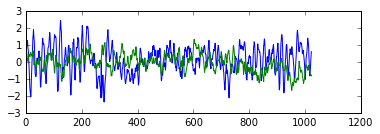

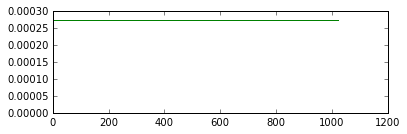

In [4]:
plt.subplot(211)
plt.plot(train_dataset[13,0,:,0])
plt.plot(train_dataset[15,0,:,1])

plt.figure(2)
plt.subplot(211)
idx = 4
plt.plot(valid_dataset[idx,0,:,0])
plt.plot(valid_dataset[idx,0,:,1])

## EEGNET implementation

Ideas
  - Condition classification based on sensor?
  
Part of https://arxiv.org/pdf/1609.03499.pdf that most concerns classification:
"As a last experiment we looked at speech recognition with WaveNets on the TIMIT (Garofolo et al., 1993) dataset. For this task we added a mean-pooling layer after the dilation convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160 x downsampling). The pooling layer was followed by a few non-causal convolutions. We trained WaveNet with two loss terms, one to predict the next sample and one to classify the frame, the model generalized better than with a single loss and achieved 18.8 PER on the test set, which is to our knowledge the best score obtained from a model trained directly on raw audio on TIMIT."

In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
#How many files are supplied per batch.
batch_size=1
#A list with the dilation factor for each layer.
dilations=[1, 2, 4, 8, 16, 32, 64, 128]
#Samples in each convolution.
filter_width=2
#How many filters to learn for the input.
input_channels=16
#How many filters to learn for the residual.
residual_channels=64
#How many filters to learn for the dilation convolution.
dilation_channels=32
#How many filters to learn for the softmax output.
skip_channels=64
#Samples after pooling, equal to receptive field size
size_after_pool=256 #approx. sum(dilations)
#Hidden layer size for fully connected layer
hidden_size=16
#number of steps after which learning rate is decayed
decay_steps=100

#Construct computation graph
graph = tf.Graph()

#activation function
actfunc = tf.nn.elu

with graph.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, 1, train_dataset.shape[2], train_dataset.shape[3]))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    
    def weights_variable(name, shape):
        initializer = tf.contrib.layers.xavier_initializer_conv2d()
        return tf.Variable(initializer(shape=shape), name=name)
    
    def bias_variable(name, shape):
        return tf.Variable(tf.zeros(shape=shape), name=name)
    
    #Variables
    var = dict()
    with tf.variable_scope('eegnet'):
        var['causal'] = dict()
        with tf.variable_scope('causal'):
            var['causal']['wfilter'] = weights_variable("wfilter", [1, filter_width, input_channels, 
                                                                    residual_channels])
            var['causal']['bfilter'] = bias_variable("bfilter", [residual_channels])
            
            tf.histogram_summary('causal_wfilter', var['causal']['wfilter'])
            tf.histogram_summary('causal_bfilter', var['causal']['bfilter'])
        
        var['dilation'] = list()
        with tf.variable_scope('dilation'):
            for idx, dilation in enumerate(dilations):
                with tf.variable_scope('layer{}'.format(idx)):
                    var['dilation'].append(dict())
                    #Filter
                    var['dilation'][idx]['wfilter'] = weights_variable("wfilter", [1, filter_width, 
                                                                                   residual_channels, 
                                                                                   dilation_channels])
                    var['dilation'][idx]['bfilter'] = bias_variable("bfilter", [dilation_channels])
                    #Gate
                    var['dilation'][idx]['wgate'] = weights_variable("wgate", [1, filter_width, 
                                                                               residual_channels, 
                                                                               dilation_channels])
                    var['dilation'][idx]['bgate'] = bias_variable("bgate", [dilation_channels])    
                    # 1x1 conv for dense contribution
                    var['dilation'][idx]['wdense'] = weights_variable("wdense", [1, 1, dilation_channels, 
                                                                                 residual_channels])
                    var['dilation'][idx]['bdense'] = bias_variable("bdense", [residual_channels])
                    # 1x1 conv for skip contribution
                    var['dilation'][idx]['wskip'] = weights_variable("wskip", [1, 1, dilation_channels, 
                                                                               skip_channels])
                    var['dilation'][idx]['bskip'] = bias_variable("bskip", [skip_channels])
                    
                    tf.histogram_summary('dilation_{}'.format(idx) + '_wfilter', var['dilation'][idx]['wfilter'])
                    tf.histogram_summary('dilation_{}'.format(idx) + '_bfilter', var['dilation'][idx]['bfilter'])
                    tf.histogram_summary('dilation_{}'.format(idx) + '_wgate', var['dilation'][idx]['wgate'])
                    tf.histogram_summary('dilation_{}'.format(idx) + '_bgate', var['dilation'][idx]['bgate'])
                    tf.histogram_summary('dilation_{}'.format(idx) + '_wdense', var['dilation'][idx]['wdense'])
                    tf.histogram_summary('dilation_{}'.format(idx) + '_bdense', var['dilation'][idx]['bdense'])
                    tf.histogram_summary('dilation_{}'.format(idx) + '_wskip', var['dilation'][idx]['wskip'])
                    tf.histogram_summary('dilation_{}'.format(idx) + '_bskip', var['dilation'][idx]['bskip'])
            
        var['skipsum'] = dict()
        with tf.variable_scope('output'):
            var['skipsum']['wsum'] = weights_variable("wsum", [1, 1, skip_channels, skip_channels])
            var['skipsum']['bsum'] = bias_variable("bsum", [skip_channels])
            
            tf.histogram_summary('skipsum_wsum', var['skipsum']['wsum'])
            tf.histogram_summary('skipsum_bsum', var['skipsum']['bsum'])
            
        var['output'] = dict()
        with tf.variable_scope('output'):
            var['output']['wfullcon'] = weights_variable('wfullcon', [size_after_pool * skip_channels, hidden_size])
            var['output']['bfullcon'] = bias_variable('bfullcon', [hidden_size])
            var['output']['wlabel'] = weights_variable('wlabel', [hidden_size, num_labels])
            var['output']['blabel'] = bias_variable('wlabel', [num_labels])
            
            tf.histogram_summary('output_wfullcon', var['output']['wfullcon'])
            tf.histogram_summary('output_bfullcon', var['output']['bfullcon'])
            tf.histogram_summary('output_wlabel', var['output']['wlabel'])
            tf.histogram_summary('output_blabel', var['output']['blabel'])

            
    def dilation_layer(batch_data, layer_idx, dilation):
        '''Creates a single causal dilation convolution layer.
        The layer contains a gated filter that connects to dense output
        and to a skip connection:
               |-> [gate]   -|        |-> 1x1 conv -> skip output
               |             |-> (*) -| 
        input -|-> [filter] -|        |-> 1x1 conv -|
               |                                    |-> (+) -> dense output
               |------------------------------------|
        Where `[gate]` and `[filter]` are causal convolutions with a
        non-linear activation at the output.
        '''
        wfilter = var['dilation'][layer_idx]['wfilter']
        bfilter = var['dilation'][layer_idx]['bfilter']
        wgate = var['dilation'][layer_idx]['wgate']
        bgate = var['dilation'][layer_idx]['bgate']
        wdense = var['dilation'][layer_idx]['wdense']
        bdense = var['dilation'][layer_idx]['bdense']
        wskip = var['dilation'][layer_idx]['wskip']
        bskip = var['dilation'][layer_idx]['bskip']
        #Filter part
        conv_filter = tf.nn.atrous_conv2d(batch_data, wfilter, dilation, padding='SAME', name='filter')
        conv_filter = tf.tanh(tf.add(conv_filter, bfilter)) 
        #Gated part
        conv_gate = tf.nn.atrous_conv2d(batch_data, wgate, dilation, padding='SAME', name='gate')
        conv_gate = tf.sigmoid(tf.add(conv_gate, bgate))
        # filter * gated output
        hidden = tf.mul(conv_filter, conv_gate)
        # The 1x1 conv to produce the dense contribution.
        conv_dense = tf.nn.conv2d(hidden, wdense, [1, 1, 1, 1], padding="SAME", name="dense")
        conv_dense = tf.add(tf.add(conv_dense, bdense), batch_data) # add input back (residual part)
        # The 1x1 conv to produce the skip contribution.
        conv_skip = tf.nn.conv2d(hidden, wskip, [1, 1, 1, 1], padding="SAME", name="skip")
        # output to final decision softmax layer
        conv_skip = tf.add(conv_skip, bskip)

        return conv_skip, conv_dense
     
        
    def network(batch_data):
        outputs = list()
        current_layer = batch_data

        # Process input with causal convolution layer
        with tf.name_scope('causal_layer'):
            current_layer = tf.nn.conv2d(current_layer, var['causal']['wfilter'], [1, 1, 1, 1], padding='SAME')
            current_layer = tf.add(current_layer, var['causal']['bfilter'])

        # Process with dilation layers
        with tf.name_scope('dilation_stack'):
            for layer_index, dilation in enumerate(dilations):
                with tf.name_scope('layer{}'.format(layer_index)):
                    output, current_layer = dilation_layer(current_layer, layer_index, dilation)
                    outputs.append(output)
        
        # Sum and process skip outputs from all dilation layers
        with tf.name_scope('skipsum'):
            hidden = actfunc(sum(outputs))
            hidden = tf.nn.conv2d(hidden, var['skipsum']['wsum'], [1, 1, 1, 1], padding="SAME")
            hidden = actfunc(tf.add(hidden, var['skipsum']['bsum']))
        
        # Dimension reduction and Fully Connected layer for classification output
        with tf.name_scope('output'):
            hidden = tf.nn.avg_pool(hidden, [1, 1, batch_samples//size_after_pool, 1], 
                                    [1, 1, batch_samples//size_after_pool, 1], padding='SAME')
            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.matmul(reshape, var['output']['wfullcon'])
            hidden = actfunc(tf.add(hidden, var['output']['bfullcon']))
            return tf.add(tf.matmul(hidden, var['output']['wlabel']), var['output']['blabel'])
        

    with tf.name_scope('eegnet'):
        logits = network(tf_train_dataset)
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
            tf.scalar_summary('loss', loss)
        with tf.name_scope('optimizer'):
            global_step = tf.Variable(0)
            learning_rate = tf.train.exponential_decay(1e-9, global_step, decay_steps, 0.96, staircase=True)
            #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=global_step)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
            tf.scalar_summary('learning_rate', learning_rate)
        with tf.name_scope('predictions'):
            train_prediction = tf.nn.softmax(logits)
            valid_prediction = tf.nn.softmax(network(tf_valid_dataset))
            
    #Merge all summaries and write to a folder
    merged = tf.merge_all_summaries()
    results_writer = tf.train.SummaryWriter('./results', graph)

print('computational graph created')

computational graph created


In [7]:
num_steps = 30

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        #_, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        _, l, predictions, summary = session.run([optimizer, loss, train_prediction, merged], feed_dict=feed_dict)
        results_writer.add_summary(summary, step)
        if (step % 3 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    results_writer.flush()
    results_writer.close()

    print('Finished training')

Initialized
Minibatch loss at step 0: 0.430886
Minibatch accuracy: 100.0%
Minibatch loss at step 3: 1.433733
Minibatch accuracy: 0.0%
Minibatch loss at step 6: 0.529521
Minibatch accuracy: 100.0%
Minibatch loss at step 9: 0.531181
Minibatch accuracy: 100.0%
Minibatch loss at step 12: 0.424153
Minibatch accuracy: 100.0%
Minibatch loss at step 15: 0.780687
Minibatch accuracy: 0.0%
Minibatch loss at step 18: 0.991157
Minibatch accuracy: 0.0%
Minibatch loss at step 21: 0.522811
Minibatch accuracy: 100.0%
Minibatch loss at step 24: 0.476975
Minibatch accuracy: 100.0%
Minibatch loss at step 27: 0.485405
Minibatch accuracy: 100.0%
Finished training
